<a href="https://colab.research.google.com/github/Sindhu213/Pytorch/blob/main/NLP/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Text Preprocessing
About Multi30k: https://pytorch.org/text/stable/datasets.html#multi30k

In [ ]:
import re
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [ ]:
## dataset: Tuple[str: src_lang(de), str: tgt_lang(en)]
train, valid, test = Multi30k()

In [ ]:
## tokenization with punctuations removed
def tokenize(text):
  tokenized = re.sub("[^\w\s]",' ',text.lower())
  return tokenized.split()

In [ ]:
def yield_tokens(iterator,lang):
  for src,tgt in iterator:
    if lang is 'de':  yield tokenize(src)
    else:  yield tokenize(tgt)

In [74]:
## might change min_freq to 1
src_vocab = build_vocab_from_iterator(yield_tokens(train,'de'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
src_vocab.set_default_index(0)

tgt_vocab = build_vocab_from_iterator(yield_tokens(train,'en'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
tgt_vocab.set_default_index(0)

In [75]:
print("source vocab_size: ",len(src_vocab))
print("target vocab_size: ",len(tgt_vocab))

source vocab_size:  7860
target vocab_size:  5883


In [76]:
de_pipeline = lambda x: src_vocab(["<bos>",*tokenize(x),"<eos>"])
en_pipeline = lambda x: tgt_vocab(["<bos>",*tokenize(x),"<eos>"])

In [84]:
def collate_batch(data_iter):   
  src,tgt_data,tgt_label = [], [], []
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for (x_batch,y_batch) in data_iter:
    src_encoded = de_pipeline(x_batch)
    src.append(torch.tensor(src_encoded,dtype=torch.int64))
    tgt_encoded = en_pipeline(y_batch)
    tgt_data.append(torch.tensor(tgt_encoded[:-1],dtype=torch.int64))
    tgt_label.append(torch.tensor(tgt_encoded[1:],dtype=torch.int64))
  
  src = pad_sequence(src,batch_first=True,padding_value=1)
  tgt_data = pad_sequence(tgt_data,batch_first=True,padding_value=1)
  tgt_label = pad_sequence(tgt_label,batch_first=True,padding_value=1)

  return src.to(device),tgt_data.to(device),tgt_label.to(device)

In [86]:
torch.manual_seed(42)
batch_size = 2    ##batch_size changed to 2 

train_dl = DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=True,collate_fn=collate_batch)
valid_dl = DataLoader(valid,batch_size=batch_size,shuffle=False,drop_last=True,collate_fn=collate_batch)
test_dl = DataLoader(test,batch_size=batch_size,shuffle=False,drop_last=True,collate_fn=collate_batch)

## Model Definition

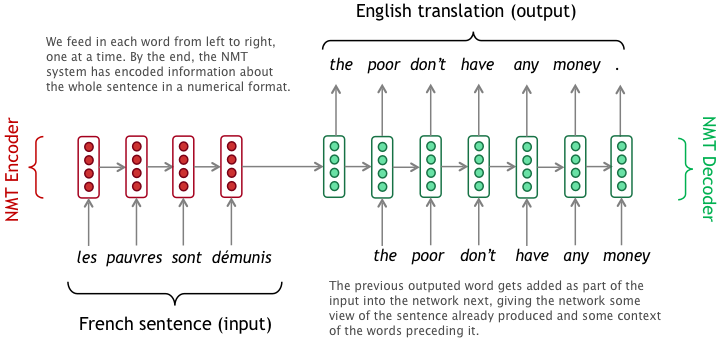

In [88]:
## might change
src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
embed_dim = 1024
rnn_hidden_size = 512

In [95]:
class NMTEncoder(nn.Module):

  def __init__(self,vocab_size,embed_dim,rnn_hidden_size):  ##add dropout
    super(NMTEncoder,self).__init__()
    self.embedding = nn.Embedding(vocab_size,embed_dim)
    self.lstm = nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)  

  def forward(self,input):
    """
    INPUT: [batch_size,len(german_sentence)]

    IMPLICIT: 
        hidden: [1,batch_size,rnn_hidden_size]
        cell: [1,batch_size,rnn_hidden_size]

    OUTPUT: 
        hidden: [1,batch_size,rnn_hidden_size]
        cell: [1,batch_size,rnn_hidden_size]
    """

    ## out: [batch_size,len(german_sentence),embed_dim]
    out = self.embedding(input)     
 
    ## out: [batch_size,len(german_sentence),rnn_hidden_size]
    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_size,rnn_hidden_size]
    out,(hidden,cell) = self.lstm(out)   

    return hidden,cell

In [105]:
class NMTDecoder(nn.Module):
  
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size):
    super(NMTDecoder,self).__init__()
    self.rnn_hidden_size = rnn_hidden_size
    self.embedding = nn.Embedding(vocab_size,embed_dim)
    self.lstm = nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)
    self.linear = nn.Linear(rnn_hidden_size,vocab_size)

  def forward(self,input,hidden,cell):
    """
    INPUT: 
        input: [batch_size,len(english_sentence)]
        hidden: [1,batch_size,rnn_hidden_size]
        cell: [1,batch_size,rnn_hidden_size]
        
    OUTPUT: [batch_size,len(english_sentence),vocab_size]
    """

    ## out: [batch_size,len(english_sentence),embed_dim]
    out = self.embedding(input)

    ## out: [batch_size,len(english_sentence),rnn_hidden_size]
    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_size,rnn_hidden_size]
    out,(hidden,cell) = self.lstm(out,(hidden,cell))

    ## out: [batch_size,len(english_sentence),vocab_size]
    out = self.linear(out)
    return out

  ## -------might delete this method-------
  def init_hidden_and_cell(self,batch_size):
    hidden = torch.zeros((1,batch_size,self.rnn_hidden_size))
    cell = torch.zeros((1,batch_size,self.rnn_hidden_size))
    return hidden,cell

In [106]:
class seq2seq(nn.Module):

  def __init__(self,src_vocab_size,tgt_vocab_size,embed_dim,rnn_hidden_size):
    super(seq2seq,self).__init__()
    self.encoder = NMTEncoder(src_vocab_size,embed_dim,rnn_hidden_size)
    self.decoder = NMTDecoder(tgt_vocab_size,embed_dim,rnn_hidden_size)
  
  def forward(self,src,tgt):
    """
    INPUT: 
      src: [batch_size,len(german_sentence)]
      tgt: [batch_size,len(english_sentence)]

    OUTPUT: [batch_size,len(english_sentence),tgt_vocab_size]
    """

    ## hidden: [1,batch_size,rnn_hidden_size]
    ## cell: [1,batch_Size,rnn_hidden_size]
    hidden,cell = self.encoder(src)

    ## out: [batch_size,len(english_sentence),tgt_vocab_size]
    out = self.decoder(tgt,hidden,cell)
    return out

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = seq2seq(src_vocab_size,tgt_vocab_size,embed_dim,rnn_hidden_size)
model.to(device)

seq2seq(
  (encoder): NMTEncoder(
    (embedding): Embedding(7860, 1024)
    (lstm): LSTM(1024, 512, batch_first=True)
  )
  (decoder): NMTDecoder(
    (embedding): Embedding(5883, 1024)
    (lstm): LSTM(1024, 512, batch_first=True)
    (linear): Linear(in_features=512, out_features=5883, bias=True)
  )
)

## Model Training and Evaluation

In [108]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [115]:
def model_train(data_iter):
  model.train()
  epoch_loss = 0.0

  ## src: [batch_size,len(german_sentence)]
  ## tgt_data: [batch_size,len(english_sentence)]
  ## tgt_label: [batch_size,len(english_sentence)]

  for src,tgt_data,tgt_label in data_iter:    
    optimizer.zero_grad()
    seq_length = tgt_label.shape[1]

    ## pred: [batch_size,len(english_sentence),tgt_vocab_size]
    pred = model(src,tgt_data)

    ## pred: [batch_size*len(english_sentence),-1]
    pred = pred.reshape(batch_size*seq_length,-1)

    ## tgt_label = [batch_size*len(english_sentence)]
    tgt_label = tgt_label.reshape(-1)

    ## loss = [tgt_vocab_size]
    loss = loss_fn(pred,tgt_label)
    epoch_loss += loss.item() * seq_length
    loss.backward()
    optimizer.step()

  return epoch_loss/seq_length   

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  train_loss = model_train(train_dl)
  print("Epoch: {}, Training loss: {}".format(epoch),train_loss)